# Part 5: Model Based Collaborative Filtering


In [180]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import matrix_factorization
from surprise import accuracy
import timeit
import os
import pandas as pd
from surprise.model_selection import KFold
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
#if you ant to save plots, make this variable True
savePlots = False

### Question 17: 

In [109]:
# Load the movielens-100k dataset (download it if needed).
file_path = os.path.expanduser('/Users/vijayravi/Documents/UCLA/Coursework/2018Winter/dataMining/projects/project3/resources/ratings.csv')
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)

In [4]:

k_vals = np.arange(2,52,2)

# Use the NMF algorithm
avgRMSE = []
avgMAE = []
execTime = []
for k in k_vals:
    #print "-" * 20
    #print "k=", k, "\n"
    start = timeit.default_timer()
    algo = matrix_factorization.NMF(n_factors=k)
    result = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    avgRMSE.append(np.mean(result['test_rmse']))
    avgMAE.append(np.mean(result['test_mae']))
    stop = timeit.default_timer()
    execTime.append(stop - start)
    #print "Time to run = ", stop - start, "seconds"

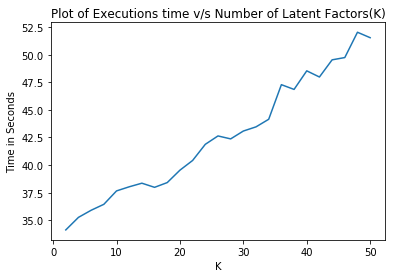

In [5]:

plt.figure()
plt.title("Plot of Executions time v/s Number of Latent Factors(K)")
plt.plot(k_vals, execTime)
plt.xlabel("K")
plt.ylabel("Time in Seconds", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
    plt.savefig("executionTime_Q17", format='png') 
plt.show()

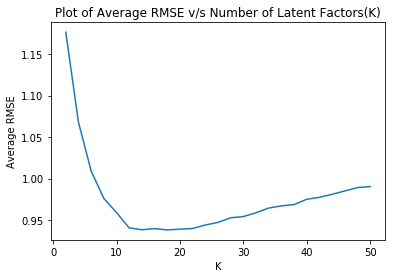

In [6]:
plt.figure()
plt.title('Plot of Average RMSE v/s Number of Latent Factors(K)')
plt.plot(k_vals, avgRMSE)
plt.xlabel("K")
plt.ylabel("Average RMSE", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
     plt.savefig("rmseVsk_Q17", format='png') 
plt.show()

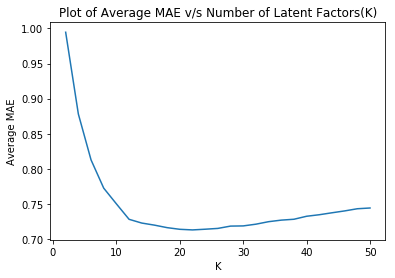

In [7]:
plt.figure()
plt.title('Plot of Average MAE v/s Number of Latent Factors(K)')
plt.plot(k_vals, avgMAE)
plt.xlabel("K")
plt.ylabel("Average MAE", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
    plt.savefig("maeVsk_Q19", format='png') 
plt.show()

### Question 18: 

In [8]:
minAvgRMSE = avgRMSE[np.argsort(avgRMSE)[0]]
print "Minimum Average RMSE is", minAvgRMSE, "\n"
bestK_RMSE = k_vals[np.argsort(avgRMSE)[0]]
print "Optimal number of latent factors that gives the minimum average RMSE is: ", bestK_RMSE, "\n"


minAvgMAE = avgMAE[np.argsort(avgMAE)[0]]
print "Minimum Average MAE is", minAvgMAE, "\n"
# bestK_MAE = k_vals[np.argsort(avgMAE)[0]]
# print "Optimal number of latent factors that gives the minimum average MAE is: ", bestK_MAE, "\n"

Minimum Average RMSE is 0.9383165084858947 

Optimal number of latent factors that gives the minimum average RMSE is:  18 

Minimum Average MAE is 0.7131371224691092 



#### Answer : The optimal number of Latent Factors is the number of Genres(18).

### Question 19, 20, 21

In [3]:
with open('ratings.csv', 'r') as f:
        reader = csv.reader(f)
        user_id = []
        movie_id = []
        rating = []
        
        for row in reader:
            user_id.append(row[0])
            movie_id.append(row[1])
            rating.append(row[2])
movie_id = movie_id[1:]
rating = rating[1:]
user_id = user_id[1:]

unique_movies = list(set(movie_id))
unique_movies = np.asfarray(unique_movies,int)

In [4]:

movie_numbers_with_less_than_two_ratings = []
for i in unique_movies:
    indexes = []
    for j in range(len(movie_id)):
        if(movie_id[j] == str(int(i))):
            indexes.append(j)
    if len(indexes) <= 2:
        movie_numbers_with_less_than_two_ratings.append(i)
movie_ints = [int(i) for i in movie_numbers_with_less_than_two_ratings]

In [7]:
movie_numbers_with_less_than_five_ratings = []
for i in unique_movies:
    indexes = []
    for j in range(len(movie_id)):
        if(movie_id[j] == str(int(i))):
            indexes.append(j)
    if len(indexes) < 5:
        movie_numbers_with_less_than_five_ratings.append(i)

In [8]:
variance = []
for i in unique_movies:
    indexes = []
    ratings = []
    for j in range(len(movie_id)):
        if(movie_id[j] == str(int(i))):
            indexes.append(j)
    for k in indexes:
        ratings.append(float(rating[k]))
    variance.append(np.var(ratings))

In [9]:
five_ratings_and_variance = []
for i in range(len(unique_movies)):
    if unique_movies[i] not in movie_numbers_with_less_than_five_ratings:
        if variance[i] > 2:
            five_ratings_and_variance.append(i)
            
five_ratings_and_variance_int = [int(i) for i in five_ratings_and_variance]

In [10]:
def trim_movies_variance(testset):
    removed_testset = []
    #print(len(testset))
    for j in range(len(testset)):
        if int(testset[j][1]) in five_ratings_and_variance_int:
            #print('yes!')
            removed_testset.append(testset[j])
    return removed_testset

def trim_movies_greater_than_2(testset):
    removed_testset = []
    #print(len(testset))
    for j in range(len(testset)):
        if int(testset[j][1]) not in movie_ints:
            #print('yes!')
            removed_testset.append(testset[j])
    return removed_testset

def trim_movies_less_or_equal_to_2(testset):
    removed_testset = []
    #print(len(testset))
    for j in range(len(testset)):
        if int(testset[j][1]) in movie_ints:
            #print('yes!')
            removed_testset.append(testset[j])
    return removed_testset

### Question 19

In [29]:
kf = KFold(n_splits=10)
k_vals = np.arange(2,52,2)

# Use the NMF algorithm
execTime = []
test_rmse_avg_full = []
print "Running"
for k in k_vals:
    start = timeit.default_timer()
    test_rmse = []
    test_mae = []
    print "-" * 50
    print"k=",k
    for trainset, testset in kf.split(data):
        removed_testset = trim_movies_greater_than_2(testset)
        algo = matrix_factorization.NMF(n_factors=k)
        algo.fit(trainset)
        predictions = algo.test(removed_testset)
        test_rmse.append(accuracy.rmse(predictions))
    test_rmse_avg_full.append(np.mean(test_rmse))
    stop = timeit.default_timer()
    execTime.append(stop - start)
    print "Time to run = ", stop - start, "seconds"


Running
--------------------------------------------------
k= 2
RMSE: 1.1772
RMSE: 1.1659
RMSE: 1.1711
RMSE: 1.1810
RMSE: 1.1721
RMSE: 1.1752
RMSE: 1.1643
RMSE: 1.1734
RMSE: 1.1535
RMSE: 1.1714
Time to run =  59.0818850994 seconds
--------------------------------------------------
k= 4
RMSE: 1.0582
RMSE: 1.0558
RMSE: 1.0464
RMSE: 1.0585
RMSE: 1.0542
RMSE: 1.0596
RMSE: 1.0610
RMSE: 1.0540
RMSE: 1.0535
RMSE: 1.0503
Time to run =  61.4834649563 seconds
--------------------------------------------------
k= 6
RMSE: 0.9907
RMSE: 0.9885
RMSE: 0.9989
RMSE: 0.9685
RMSE: 0.9995
RMSE: 1.0073
RMSE: 0.9968
RMSE: 0.9909
RMSE: 0.9912
RMSE: 0.9919
Time to run =  66.697726965 seconds
--------------------------------------------------
k= 8
RMSE: 0.9543
RMSE: 0.9620
RMSE: 0.9654
RMSE: 0.9583
RMSE: 0.9579
RMSE: 0.9577
RMSE: 0.9586
RMSE: 0.9534
RMSE: 0.9622
RMSE: 0.9628
Time to run =  70.9373290539 seconds
--------------------------------------------------
k= 10
RMSE: 0.9369
RMSE: 0.9290
RMSE: 0.9356
RMSE:

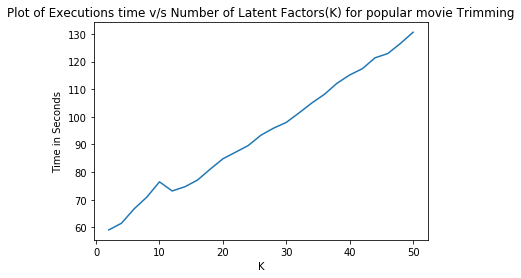

In [30]:
plt.figure()
plt.title("Plot of Executions time v/s Number of Latent Factors(K) for popular movie Trimming")
plt.plot(k_vals, execTime)
plt.xlabel("K")
plt.ylabel("Time in Seconds", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
    plt.savefig("executionTimepopularData_Q19", format='png') 
plt.show()

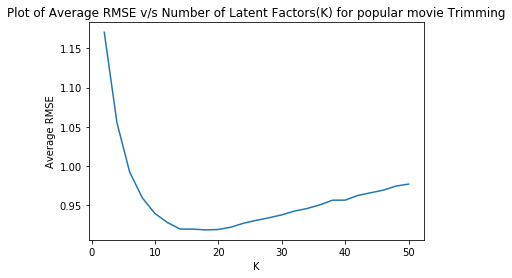

In [31]:
plt.figure()
plt.title('Plot of Average RMSE v/s Number of Latent Factors(K) for popular movie Trimming')
plt.plot(k_vals, test_rmse_avg_full)
plt.xlabel("K")
plt.ylabel("Average RMSE", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
     plt.savefig("rmseVsk_Q19", format='png') 
plt.show()

In [32]:
minAvgRMSE = test_rmse_avg_full[np.argsort(test_rmse_avg_full)[0]]
print "Minimum Average RMSE for popular movie trimming dataset is", minAvgRMSE, "\n"

Minimum Average RMSE for popular movie trimming dataset is 0.918312225144472 



### Question 20

In [33]:
kf = KFold(n_splits=10)
k_vals = np.arange(2,52,2)

# Use the NMF algorithm
execTime = []
test_rmse_avg_full = []
print "Running"
for k in k_vals:
    start = timeit.default_timer()
    test_rmse = []
    test_mae = []
    print "-" * 50
    print"k=",k
    for trainset, testset in kf.split(data):
        removed_testset = trim_movies_less_or_equal_to_2(testset)
        algo = matrix_factorization.NMF(n_factors=k)
        algo.fit(trainset)
        predictions = algo.test(removed_testset)
        test_rmse.append(accuracy.rmse(predictions))
    test_rmse_avg_full.append(np.mean(test_rmse))
    stop = timeit.default_timer()
    execTime.append(stop - start)
    print "Time to run = ", stop - start, "seconds"


Running
--------------------------------------------------
k= 2
RMSE: 1.1388
RMSE: 1.2839
RMSE: 1.2685
RMSE: 1.2655
RMSE: 1.2934
RMSE: 1.3392
RMSE: 1.2832
RMSE: 1.2716
RMSE: 1.2581
RMSE: 1.2779
Time to run =  52.7806129456 seconds
--------------------------------------------------
k= 4
RMSE: 1.2592
RMSE: 1.2060
RMSE: 1.2707
RMSE: 1.2944
RMSE: 1.2152
RMSE: 1.2724
RMSE: 1.2608
RMSE: 1.2773
RMSE: 1.2104
RMSE: 1.3364
Time to run =  56.0436069965 seconds
--------------------------------------------------
k= 6
RMSE: 1.2947
RMSE: 1.2920
RMSE: 1.3118
RMSE: 1.2848
RMSE: 1.2240
RMSE: 1.2452
RMSE: 1.2531
RMSE: 1.1920
RMSE: 1.2300
RMSE: 1.2235
Time to run =  59.2255370617 seconds
--------------------------------------------------
k= 8
RMSE: 1.2700
RMSE: 1.3024
RMSE: 1.2616
RMSE: 1.2619
RMSE: 1.2701
RMSE: 1.2435
RMSE: 1.2405
RMSE: 1.2286
RMSE: 1.2190
RMSE: 1.2293
Time to run =  62.1573150158 seconds
--------------------------------------------------
k= 10
RMSE: 1.2553
RMSE: 1.2211
RMSE: 1.3105
RMSE

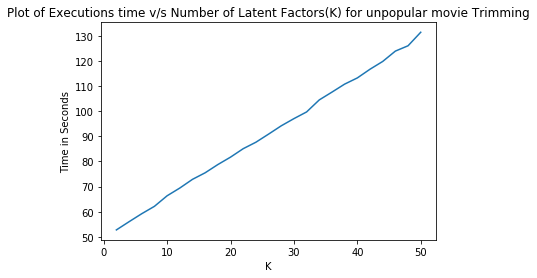

In [34]:
plt.figure()
plt.title("Plot of Executions time v/s Number of Latent Factors(K) for unpopular movie Trimming")
plt.plot(k_vals, execTime)
plt.xlabel("K")
plt.ylabel("Time in Seconds", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
    plt.savefig("executionTimepopularData_Q20", format='png') 
plt.show()

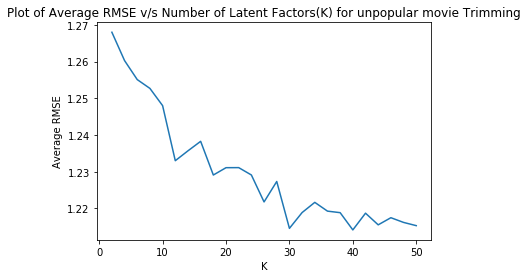

In [35]:
plt.figure()
plt.title('Plot of Average RMSE v/s Number of Latent Factors(K) for unpopular movie Trimming')
plt.plot(k_vals, test_rmse_avg_full)
plt.xlabel("K")
plt.ylabel("Average RMSE", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
     plt.savefig("rmseVsk_Q20", format='png') 
plt.show()

In [36]:
minAvgRMSE = test_rmse_avg_full[np.argsort(test_rmse_avg_full)[0]]
print "Minimum Average RMSE for unpopular movie trimming dataset is", minAvgRMSE, "\n"

Minimum Average RMSE for unpopular movie trimming dataset is 1.2141599709843718 



### Question 21

In [37]:
kf = KFold(n_splits=10)
k_vals = np.arange(2,52,2)

# Use the NMF algorithm
execTime = []
test_rmse_avg_full = []
print "Running"
for k in k_vals:
    start = timeit.default_timer()
    test_rmse = []
    test_mae = []
    print "-" * 50
    print"k=",k
    for trainset, testset in kf.split(data):
        removed_testset = trim_movies_variance(testset)
        algo = matrix_factorization.NMF(n_factors=k)
        algo.fit(trainset)
        predictions = algo.test(removed_testset)
        test_rmse.append(accuracy.rmse(predictions))
    test_rmse_avg_full.append(np.mean(test_rmse))
    stop = timeit.default_timer()
    execTime.append(stop - start)
    print "Time to run = ", stop - start, "seconds"

Running
--------------------------------------------------
k= 2
RMSE: 1.1780
RMSE: 1.0950
RMSE: 1.1986
RMSE: 1.2159
RMSE: 1.1144
RMSE: 1.2620
RMSE: 1.3565
RMSE: 1.2939
RMSE: 1.1947
RMSE: 1.2960
Time to run =  47.240489006 seconds
--------------------------------------------------
k= 4
RMSE: 1.1538
RMSE: 1.1291
RMSE: 1.0648
RMSE: 1.1201
RMSE: 1.2218
RMSE: 1.2552
RMSE: 1.2637
RMSE: 1.2174
RMSE: 1.2106
RMSE: 0.9634
Time to run =  49.9709339142 seconds
--------------------------------------------------
k= 6
RMSE: 0.9975
RMSE: 1.0937
RMSE: 1.2449
RMSE: 1.1148
RMSE: 0.9436
RMSE: 1.0361
RMSE: 1.3302
RMSE: 1.0496
RMSE: 1.1659
RMSE: 1.0580
Time to run =  52.8335409164 seconds
--------------------------------------------------
k= 8
RMSE: 1.1031
RMSE: 1.0102
RMSE: 1.1931
RMSE: 1.0022
RMSE: 1.1597
RMSE: 1.0475
RMSE: 1.1387
RMSE: 0.9208
RMSE: 1.1806
RMSE: 1.1582
Time to run =  56.1815190315 seconds
--------------------------------------------------
k= 10
RMSE: 1.1201
RMSE: 0.9633
RMSE: 1.0312
RMSE:

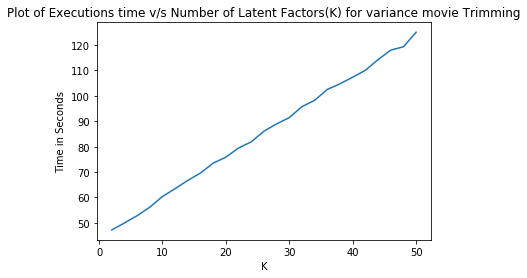

In [38]:
plt.figure()
plt.title("Plot of Executions time v/s Number of Latent Factors(K) for variance movie Trimming")
plt.plot(k_vals, execTime)
plt.xlabel("K")
plt.ylabel("Time in Seconds", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
    plt.savefig("executionTimepopularData_Q20", format='png') 
plt.show()

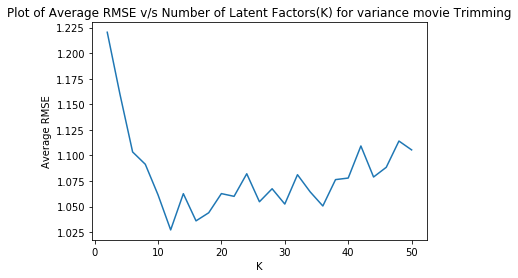

In [39]:
plt.figure()
plt.title('Plot of Average RMSE v/s Number of Latent Factors(K) for variance movie Trimming')
plt.plot(k_vals, test_rmse_avg_full)
plt.xlabel("K")
plt.ylabel("Average RMSE", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
     plt.savefig("rmseVsk_Q20", format='png') 
plt.show()

In [40]:
minAvgRMSE = test_rmse_avg_full[np.argsort(test_rmse_avg_full)[0]]
print "Minimum Average RMSE for Variance movie trimming dataset is", minAvgRMSE, "\n"

Minimum Average RMSE for Variance movie trimming dataset is 1.0271844032861093 



### Question 22

In [105]:
trainset, testset = train_test_split(data, test_size=.10)
algo = matrix_factorization.NMF(n_factors=18) #best K from question 18. 
algo.fit(trainset)
predictions = algo.test(testset)
#roc_curve(testset,predictions)

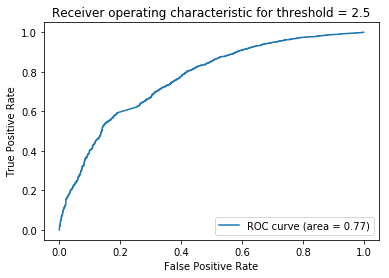

 Area under the curve for Threshold =  2.5 is,  0.7667640519789893


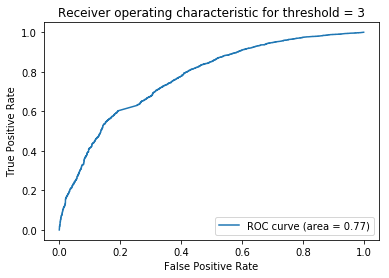

 Area under the curve for Threshold =  3 is,  0.7698489466884317


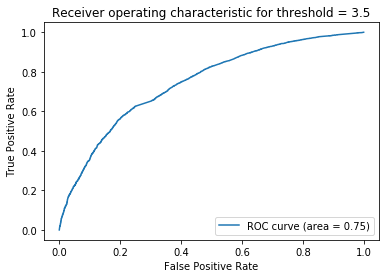

 Area under the curve for Threshold =  3.5 is,  0.7463053623862416


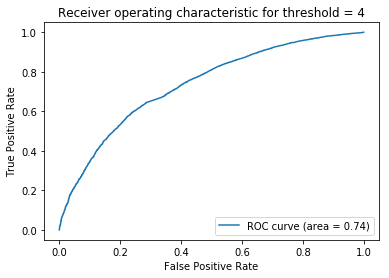

 Area under the curve for Threshold =  4 is,  0.7354076791666233


In [106]:
trueValue = []
predValue = []
thresholds = [2.5,3,3.5,4]
for threshold in thresholds:
    for i in range(len(testset)):
        if testset[i][2] >= threshold: #threshold
            trueValue.append(1)
        else:
            trueValue.append(0)

        predValue.append(predictions[i][3])

    fpr, tpr, thresholds = roc_curve(trueValue,predValue)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for threshold = ' + str(threshold))
    plt.legend(loc="lower right")
    plt.show()
    if savePlots:
         plt.savefig("roc_Q22", format='png') 
    plt.show()
    print " Area under the curve for Threshold = ",threshold, "is, ", roc_auc

### Question 23

In [168]:
trainSet = data.build_full_trainset()
algo = matrix_factorization.NMF(n_factors=20) #best K from question 18. 

algo.fit(trainSet)
V = algo.qi
U = algo.pu

with open('movies.csv', 'r') as f:
        reader = csv.reader(f)

        movie_id = []
        movieName = []
        movieGenre = []
        
        for row in reader:
            movie_id.append(row[0])
            movieName.append(row[1])
            movieGenre.append(row[2])
movie_id = movie_id[1:]
movieName = movieName[1:]
movieGenre = movieGenre[1:]

In [169]:
latentFactors = V.shape[1]

In [173]:
for k in range(latentFactors): #reduce this if you don't want top 10 movies for all columns. 
    print "-"*30
    print "Column number", k
    top10 = np.argsort(V[:,k])[-11: -1]
    print "Top 10 movie Genres are:"
    for i in top10:
        print movieGenre[i]

------------------------------
Column number 0
Top 10 movie Genres are:
Action|Drama|Thriller
Comedy|Horror
Comedy|Musical
Drama
Adventure|Fantasy
Drama
Drama
Crime|Drama|Film-Noir
Crime|Thriller
Children|Comedy|Fantasy
------------------------------
Column number 1
Top 10 movie Genres are:
Drama
Action|Thriller
Drama|Romance
Comedy|Drama|Romance
Action|Adventure|Drama
Comedy
War
Horror|Mystery|Thriller
Drama
Action|Adventure|Drama
------------------------------
Column number 2
Top 10 movie Genres are:
Children|Comedy
Horror
Drama
Action|Adventure|Drama|War
Sci-Fi
Drama|Romance
Comedy|Fantasy
Comedy|Drama
Comedy|Romance
Documentary|Musical
------------------------------
Column number 3
Top 10 movie Genres are:
Action|Adventure|Comedy
Drama
Action|Sci-Fi|Thriller
Comedy|Crime
Horror
Crime|Drama
Drama
Action|Drama|Thriller|War
Action|Adventure|Comedy|Sci-Fi|Thriller
Action|Mystery|Sci-Fi|Thriller
------------------------------
Column number 4
Top 10 movie Genres are:
Comedy|Drama
Childre

### Question 24

In [185]:
file_path = os.path.expanduser('/Users/vijayravi/Documents/UCLA/Coursework/2018Winter/dataMining/projects/project3/resources/ratings.csv')
reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)
data = Dataset.load_from_file(file_path, reader=reader)

In [194]:
k_vals = np.arange(2,52,2)
test_rmse_avg_full = []
test_mae_avg_full = []
test_rmse_avg_full = []
kf = KFold(n_splits=10)
test_rmse = []
test_mae = []
execTime = []
for k in k_vals:
    start = timeit.default_timer()
    print "-"*40
    print"K = ", k
    for trainset, testset in kf.split(data):
        algo = matrix_factorization.SVD(n_factors=k)
        algo.fit(trainset)
        predictions = algo.test(testset)
        test_rmse.append(accuracy.rmse(predictions))
        test_mae.append(accuracy.mae(predictions))
    test_rmse_avg_full.append(np.mean(test_rmse))
    test_mae_avg_full.append(np.mean(test_mae))
    stop = timeit.default_timer()
    execTime.append(stop - start)
    print "Time to run = ", stop - start, "seconds"


----------------------------------------
K =  2
RMSE: 0.8813
MAE:  0.6815
RMSE: 0.8839
MAE:  0.6824
RMSE: 0.9003
MAE:  0.6947
RMSE: 0.8949
MAE:  0.6914
RMSE: 0.8866
MAE:  0.6786
RMSE: 0.8847
MAE:  0.6841
RMSE: 0.8863
MAE:  0.6812
RMSE: 0.8746
MAE:  0.6717
RMSE: 0.8910
MAE:  0.6838
RMSE: 0.8966
MAE:  0.6906
Time to run =  20.9000132084 seconds
----------------------------------------
K =  4
RMSE: 0.8854
MAE:  0.6811
RMSE: 0.8802
MAE:  0.6807
RMSE: 0.8880
MAE:  0.6846
RMSE: 0.8936
MAE:  0.6915
RMSE: 0.8955
MAE:  0.6909
RMSE: 0.8878
MAE:  0.6836
RMSE: 0.8975
MAE:  0.6858
RMSE: 0.8879
MAE:  0.6822
RMSE: 0.8849
MAE:  0.6802
RMSE: 0.8803
MAE:  0.6813
Time to run =  21.787127018 seconds
----------------------------------------
K =  6
RMSE: 0.8754
MAE:  0.6769
RMSE: 0.8994
MAE:  0.6941
RMSE: 0.8864
MAE:  0.6849
RMSE: 0.8928
MAE:  0.6890
RMSE: 0.8923
MAE:  0.6831
RMSE: 0.8980
MAE:  0.6907
RMSE: 0.8870
MAE:  0.6787
RMSE: 0.8810
MAE:  0.6799
RMSE: 0.8838
MAE:  0.6815
RMSE: 0.8836
MAE:  0.6819
Tim

RMSE: 0.8893
MAE:  0.6832
RMSE: 0.8889
MAE:  0.6864
Time to run =  45.1232299805 seconds
----------------------------------------
K =  50
RMSE: 0.8985
MAE:  0.6915
RMSE: 0.8991
MAE:  0.6920
RMSE: 0.8999
MAE:  0.6921
RMSE: 0.8827
MAE:  0.6750
RMSE: 0.8943
MAE:  0.6874
RMSE: 0.8853
MAE:  0.6831
RMSE: 0.8888
MAE:  0.6822
RMSE: 0.8720
MAE:  0.6746
RMSE: 0.8783
MAE:  0.6774
RMSE: 0.8975
MAE:  0.6856
Time to run =  44.3993029594 seconds


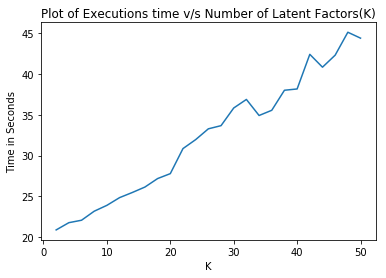

In [195]:
plt.figure()
plt.title("Plot of Executions time v/s Number of Latent Factors(K)")
plt.plot(k_vals, execTime)
plt.xlabel("K")
plt.ylabel("Time in Seconds", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
    plt.savefig("executionTime_Q24", format='png') 
plt.show()

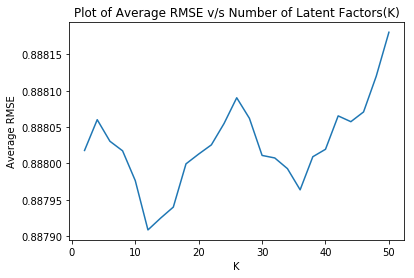

In [196]:
plt.figure()
plt.title('Plot of Average RMSE v/s Number of Latent Factors(K)')
plt.plot(k_vals, test_rmse_avg_full)
plt.xlabel("K")
plt.ylabel("Average RMSE", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
     plt.savefig("rmseVsk_Q24", format='png') 
plt.show()

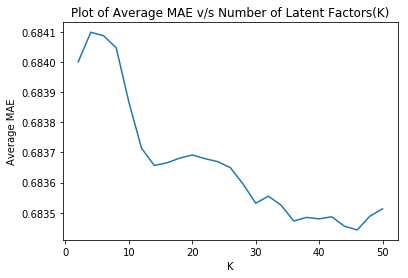

In [197]:
plt.figure()
plt.title('Plot of Average MAE v/s Number of Latent Factors(K)')
plt.plot(k_vals, test_mae_avg_full)
plt.xlabel("K")
plt.ylabel("Average MAE", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
    plt.savefig("maeVsk_Q24", format='png') 
plt.show()

### Question 25

In [198]:
minAvgRMSE = test_rmse_avg_full[np.argsort(test_rmse_avg_full)[0]]
print "Minimum Average RMSE is", minAvgRMSE, "\n"
bestK_RMSE = k_vals[np.argsort(test_rmse_avg_full)[0]]
print "Optimal number of latent factors that gives the minimum average RMSE is: ", bestK_RMSE, "\n"


minAvgMAE = test_mae_avg_full[np.argsort(test_mae_avg_full)[0]]
print "Minimum Average MAE is", minAvgMAE, "\n"

Minimum Average RMSE is 0.8879085166788035 

Optimal number of latent factors that gives the minimum average RMSE is:  12 

Minimum Average MAE is 0.6834434612962847 



### Question 26

In [199]:
k_vals = np.arange(2,52,2)
test_rmse_avg_full = []
test_mae_avg_full = []
test_rmse_avg_full = []
kf = KFold(n_splits=10)
test_rmse = []
test_mae = []
execTime = []
for k in k_vals:
    start = timeit.default_timer()
    print "-"*40
    print"K = ", k
    for trainset, testset in kf.split(data):
        algo = matrix_factorization.SVD(n_factors=k)
        algo.fit(trainset)
        removed_testset = trim_movies_greater_than_2(testset)
        predictions = algo.test(removed_testset)
        test_rmse.append(accuracy.rmse(predictions))
        test_mae.append(accuracy.mae(predictions))
    test_rmse_avg_full.append(np.mean(test_rmse))
    test_mae_avg_full.append(np.mean(test_mae))
    stop = timeit.default_timer()
    execTime.append(stop - start)
    print "Time to run = ", stop - start, "seconds"


----------------------------------------
K =  2
RMSE: 0.8901
MAE:  0.6856
RMSE: 0.8785
MAE:  0.6771
RMSE: 0.8852
MAE:  0.6780
RMSE: 0.8907
MAE:  0.6829
RMSE: 0.8799
MAE:  0.6792
RMSE: 0.8719
MAE:  0.6669
RMSE: 0.8731
MAE:  0.6727
RMSE: 0.8690
MAE:  0.6720
RMSE: 0.8803
MAE:  0.6805
RMSE: 0.8774
MAE:  0.6776
Time to run =  30.0723259449 seconds
----------------------------------------
K =  4
RMSE: 0.8813
MAE:  0.6805
RMSE: 0.8856
MAE:  0.6799
RMSE: 0.8871
MAE:  0.6852
RMSE: 0.8718
MAE:  0.6726
RMSE: 0.8771
MAE:  0.6786
RMSE: 0.8719
MAE:  0.6698
RMSE: 0.8775
MAE:  0.6770
RMSE: 0.8824
MAE:  0.6768
RMSE: 0.8834
MAE:  0.6784
RMSE: 0.8744
MAE:  0.6705
Time to run =  30.6479160786 seconds
----------------------------------------
K =  6
RMSE: 0.8942
MAE:  0.6873
RMSE: 0.8835
MAE:  0.6811
RMSE: 0.8562
MAE:  0.6608
RMSE: 0.8850
MAE:  0.6764
RMSE: 0.8716
MAE:  0.6699
RMSE: 0.8786
MAE:  0.6770
RMSE: 0.8822
MAE:  0.6802
RMSE: 0.8821
MAE:  0.6805
RMSE: 0.8834
MAE:  0.6812
RMSE: 0.8777
MAE:  0.6756
Ti

RMSE: 0.8819
MAE:  0.6775
RMSE: 0.8936
MAE:  0.6817
Time to run =  49.0184209347 seconds
----------------------------------------
K =  50
RMSE: 0.8778
MAE:  0.6767
RMSE: 0.8810
MAE:  0.6776
RMSE: 0.8822
MAE:  0.6797
RMSE: 0.8795
MAE:  0.6755
RMSE: 0.8714
MAE:  0.6718
RMSE: 0.8918
MAE:  0.6842
RMSE: 0.8864
MAE:  0.6807
RMSE: 0.8830
MAE:  0.6796
RMSE: 0.8941
MAE:  0.6852
RMSE: 0.8675
MAE:  0.6702
Time to run =  48.2251000404 seconds


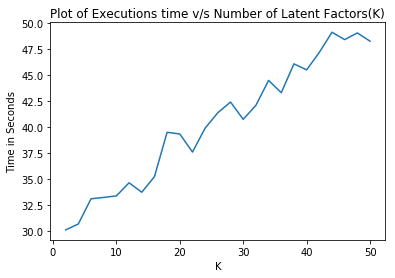

In [200]:
plt.figure()
plt.title("Plot of Executions time v/s Number of Latent Factors(K)")
plt.plot(k_vals, execTime)
plt.xlabel("K")
plt.ylabel("Time in Seconds", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
    plt.savefig("executionTime_Q26", format='png') 
plt.show()

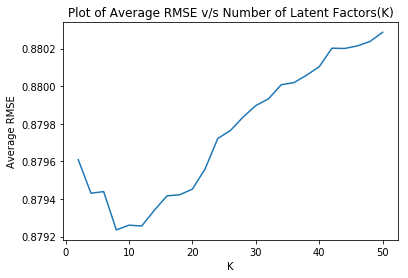

In [201]:
plt.figure()
plt.title('Plot of Average RMSE v/s Number of Latent Factors(K)')
plt.plot(k_vals, test_rmse_avg_full)
plt.xlabel("K")
plt.ylabel("Average RMSE", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
     plt.savefig("rmseVsk_Q26", format='png') 
plt.show()

In [202]:
minAvgRMSE = test_rmse_avg_full[np.argsort(test_rmse_avg_full)[0]]
print "Minimum Average RMSE is", minAvgRMSE, "\n"

Minimum Average RMSE is 0.8792355879174609 



### Question 27

In [203]:
trim_movies_less_or_equal_to_2
k_vals = np.arange(2,52,2)
test_rmse_avg_full = []
test_mae_avg_full = []
test_rmse_avg_full = []
kf = KFold(n_splits=10)
test_rmse = []
test_mae = []
execTime = []
for k in k_vals:
    start = timeit.default_timer()
    print "-"*40
    print"K = ", k
    for trainset, testset in kf.split(data):
        algo = matrix_factorization.SVD(n_factors=k)
        algo.fit(trainset)
        removed_testset = trim_movies_greater_than_2(testset)
        predictions = algo.test(removed_testset)
        test_rmse.append(accuracy.rmse(predictions))
        test_mae.append(accuracy.mae(predictions))
    test_rmse_avg_full.append(np.mean(test_rmse))
    test_mae_avg_full.append(np.mean(test_mae))
    stop = timeit.default_timer()
    execTime.append(stop - start)
    print "Time to run = ", stop - start, "seconds"


----------------------------------------
K =  2
RMSE: 0.8811
MAE:  0.6804
RMSE: 0.8734
MAE:  0.6721
RMSE: 0.8737
MAE:  0.6751
RMSE: 0.8870
MAE:  0.6839
RMSE: 0.8902
MAE:  0.6837
RMSE: 0.8838
MAE:  0.6795
RMSE: 0.8895
MAE:  0.6845
RMSE: 0.8679
MAE:  0.6674
RMSE: 0.8767
MAE:  0.6732
RMSE: 0.8729
MAE:  0.6727
Time to run =  28.3696057796 seconds
----------------------------------------
K =  4
RMSE: 0.8817
MAE:  0.6798
RMSE: 0.8804
MAE:  0.6807
RMSE: 0.8835
MAE:  0.6764
RMSE: 0.8875
MAE:  0.6803
RMSE: 0.8792
MAE:  0.6751
RMSE: 0.8879
MAE:  0.6843
RMSE: 0.8645
MAE:  0.6655
RMSE: 0.8758
MAE:  0.6769
RMSE: 0.8764
MAE:  0.6723
RMSE: 0.8753
MAE:  0.6746
Time to run =  28.7286000252 seconds
----------------------------------------
K =  6
RMSE: 0.8786
MAE:  0.6737
RMSE: 0.8865
MAE:  0.6811
RMSE: 0.8839
MAE:  0.6810
RMSE: 0.8909
MAE:  0.6864
RMSE: 0.8741
MAE:  0.6766
RMSE: 0.8877
MAE:  0.6822
RMSE: 0.8788
MAE:  0.6774
RMSE: 0.8626
MAE:  0.6659
RMSE: 0.8794
MAE:  0.6757
RMSE: 0.8819
MAE:  0.6767
Ti

RMSE: 0.8903
MAE:  0.6825
RMSE: 0.8730
MAE:  0.6732
Time to run =  49.5282809734 seconds
----------------------------------------
K =  50
RMSE: 0.8867
MAE:  0.6795
RMSE: 0.8786
MAE:  0.6757
RMSE: 0.8771
MAE:  0.6745
RMSE: 0.8814
MAE:  0.6798
RMSE: 0.8725
MAE:  0.6704
RMSE: 0.8767
MAE:  0.6761
RMSE: 0.8746
MAE:  0.6702
RMSE: 0.8950
MAE:  0.6887
RMSE: 0.8836
MAE:  0.6807
RMSE: 0.8842
MAE:  0.6769
Time to run =  49.2126591206 seconds


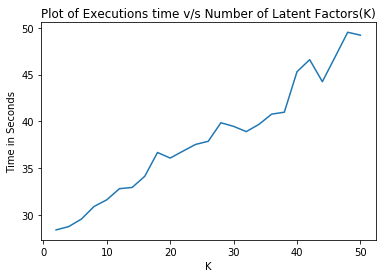

In [204]:
plt.figure()
plt.title("Plot of Executions time v/s Number of Latent Factors(K)")
plt.plot(k_vals, execTime)
plt.xlabel("K")
plt.ylabel("Time in Seconds", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
    plt.savefig("executionTime_Q27", format='png') 
plt.show()

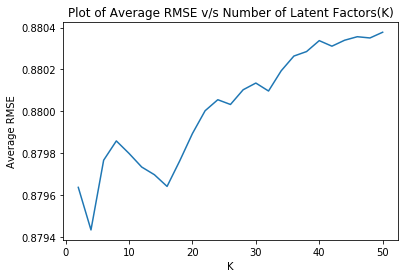

In [205]:
plt.figure()
plt.title('Plot of Average RMSE v/s Number of Latent Factors(K)')
plt.plot(k_vals, test_rmse_avg_full)
plt.xlabel("K")
plt.ylabel("Average RMSE", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
     plt.savefig("rmseVsk_Q27", format='png') 
plt.show()

In [206]:
minAvgRMSE = test_rmse_avg_full[np.argsort(test_rmse_avg_full)[0]]
print "Minimum Average RMSE is", minAvgRMSE, "\n"

Minimum Average RMSE is 0.8794345473297118 



### Question 28

In [207]:
k_vals = np.arange(2,52,2)
test_rmse_avg_full = []
test_mae_avg_full = []
test_rmse_avg_full = []
kf = KFold(n_splits=10)
test_rmse = []
test_mae = []
execTime = []
for k in k_vals:
    start = timeit.default_timer()
    print "-"*40
    print"K = ", k
    for trainset, testset in kf.split(data):
        algo = matrix_factorization.SVD(n_factors=k)
        algo.fit(trainset)
        removed_testset = trim_movies_variance(testset)
        predictions = algo.test(removed_testset)
        test_rmse.append(accuracy.rmse(predictions))
        test_mae.append(accuracy.mae(predictions))
    test_rmse_avg_full.append(np.mean(test_rmse))
    test_mae_avg_full.append(np.mean(test_mae))
    stop = timeit.default_timer()
    execTime.append(stop - start)
    print "Time to run = ", stop - start, "seconds"


----------------------------------------
K =  2
RMSE: 1.0404
MAE:  0.7822
RMSE: 0.9968
MAE:  0.7802
RMSE: 0.9176
MAE:  0.7707
RMSE: 1.0022
MAE:  0.7558
RMSE: 1.0377
MAE:  0.7963
RMSE: 1.1584
MAE:  0.9659
RMSE: 0.9622
MAE:  0.8045
RMSE: 0.8894
MAE:  0.7429
RMSE: 0.9336
MAE:  0.7596
RMSE: 0.9731
MAE:  0.7398
Time to run =  20.0983099937 seconds
----------------------------------------
K =  4
RMSE: 1.0674
MAE:  0.8335
RMSE: 0.9428
MAE:  0.7491
RMSE: 0.9273
MAE:  0.7593
RMSE: 1.0867
MAE:  0.8675
RMSE: 0.9133
MAE:  0.7567
RMSE: 1.1432
MAE:  0.9933
RMSE: 1.0666
MAE:  0.8234
RMSE: 0.8830
MAE:  0.6774
RMSE: 1.1638
MAE:  0.8734
RMSE: 0.8898
MAE:  0.7094
Time to run =  21.6263740063 seconds
----------------------------------------
K =  6
RMSE: 1.0594
MAE:  0.8662
RMSE: 0.8794
MAE:  0.6985
RMSE: 1.0758
MAE:  0.8469
RMSE: 1.1387
MAE:  0.9065
RMSE: 0.9790
MAE:  0.7703
RMSE: 0.8999
MAE:  0.7241
RMSE: 1.0041
MAE:  0.8133
RMSE: 1.0198
MAE:  0.7889
RMSE: 1.1111
MAE:  0.8344
RMSE: 0.8837
MAE:  0.7400
Ti

RMSE: 1.1613
MAE:  0.9319
RMSE: 0.9369
MAE:  0.7628
Time to run =  38.4818749428 seconds
----------------------------------------
K =  50
RMSE: 1.2273
MAE:  1.0292
RMSE: 1.2708
MAE:  0.9872
RMSE: 1.0360
MAE:  0.8337
RMSE: 0.9001
MAE:  0.6988
RMSE: 1.1680
MAE:  0.9718
RMSE: 1.0431
MAE:  0.8002
RMSE: 0.9068
MAE:  0.7673
RMSE: 1.1019
MAE:  0.8652
RMSE: 0.8266
MAE:  0.6675
RMSE: 0.7566
MAE:  0.5992
Time to run =  38.7355120182 seconds


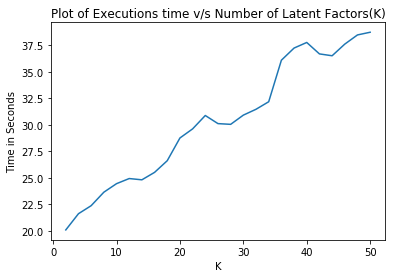

In [208]:
plt.figure()
plt.title("Plot of Executions time v/s Number of Latent Factors(K)")
plt.plot(k_vals, execTime)
plt.xlabel("K")
plt.ylabel("Time in Seconds", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
    plt.savefig("executionTime_Q28", format='png') 
plt.show()

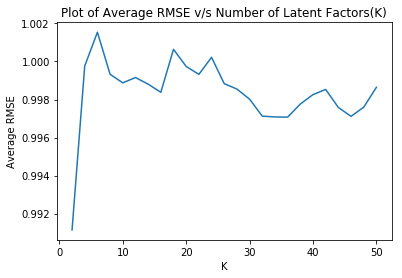

In [209]:
plt.figure()
plt.title('Plot of Average RMSE v/s Number of Latent Factors(K)')
plt.plot(k_vals, test_rmse_avg_full)
plt.xlabel("K")
plt.ylabel("Average RMSE", rotation=90)
# To save the plot, uncomment the next line. Plot is saved in folder that has the IPYNB file. 
if savePlots:
     plt.savefig("rmseVsk_Q28", format='png') 
plt.show()

In [210]:
minAvgRMSE = test_rmse_avg_full[np.argsort(test_rmse_avg_full)[0]]
print "Minimum Average RMSE is", minAvgRMSE, "\n"

Minimum Average RMSE is 0.9911452156711981 



### Question 29

In [211]:
trainset, testset = train_test_split(data, test_size=.10)
algo = matrix_factorization.SVD(n_factors=12) #best K from question 18. 
algo.fit(trainset)
predictions = algo.test(testset)
#roc_curve(testset,predictions)

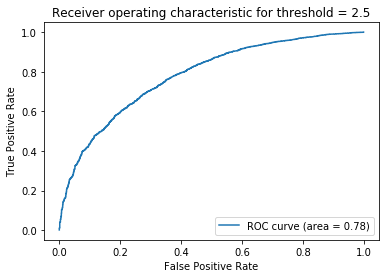

 Area under the curve for Threshold =  2.5 is,  0.7805316936610616


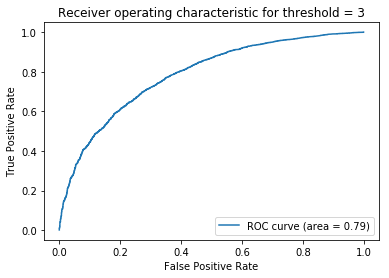

 Area under the curve for Threshold =  3 is,  0.7861756421526749


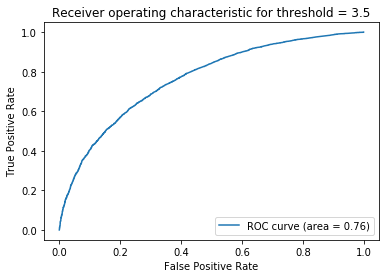

 Area under the curve for Threshold =  3.5 is,  0.7636552145565314


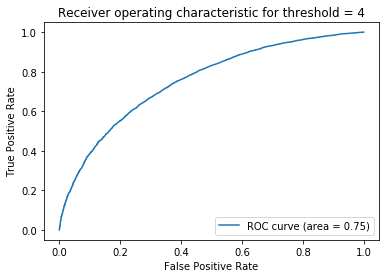

 Area under the curve for Threshold =  4 is,  0.7529945955240769


In [212]:
trueValue = []
predValue = []
thresholds = [2.5,3,3.5,4]
for threshold in thresholds:
    for i in range(len(testset)):
        if testset[i][2] >= threshold: #threshold
            trueValue.append(1)
        else:
            trueValue.append(0)

        predValue.append(predictions[i][3])

    fpr, tpr, thresholds = roc_curve(trueValue,predValue)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for threshold = ' + str(threshold))
    plt.legend(loc="lower right")
    plt.show()
    if savePlots:
         plt.savefig("roc_Q29=", format='png') 
    plt.show()
    print " Area under the curve for Threshold = ",threshold, "is, ", roc_auc